In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_preprocessing import timepoint_split, transform_indices, reindex_data, generate_interactions_matrix, generate_weights
from pure_svd import build_svd_model, svd_scoring, svd_gridsearch
from knn import uknn_scoring, uknn_gridsearch, build_uknn_model
from evaluation import model_evaluate, topn_recommendations, downvote_seen_items

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6

## Amazon-reviews

In [2]:
# !mkdir -p data/amazon_reviews
# !wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Grocery_and_Gourmet_Food.csv --no-check-certificate
# !mv Grocery_and_Gourmet_Food.csv data/amazon_reviews

In [3]:
reviews = pd.read_csv("data/amazon_reviews/Grocery_and_Gourmet_Food.csv", names=["userid", "itemid", "rating", "timestamp"])

In [4]:
len(reviews)

5074160

In [5]:
reviews.nunique()

userid        283507
itemid       2695974
rating             5
timestamp       5221
dtype: int64

In [6]:
# K-core filtering

k_filter = 10

n_interactions = reviews.groupby("userid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.userid.isin(enough)]

n_interactions = reviews.groupby("itemid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.itemid.isin(enough)]

In [7]:
len(reviews) / 1e6

0.517548

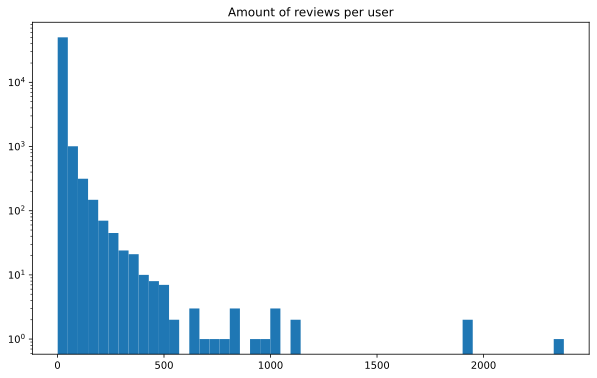

In [8]:
plt.hist(reviews.groupby("userid").size(), bins=50)
plt.yscale("log")
plt.title("Amount of reviews per user")
plt.show()

In [9]:
# Split for final evaluation
_train, _test, _holdout = timepoint_split(reviews, time_split_q=0.95)

len(_train), len(_test), len(_holdout)

(232467, 225151, 9640)

In [10]:
# Additional split for hyperparameter tuning
_trainval, _testval, _holdoutval = timepoint_split(_train, time_split_q=0.95)

len(_trainval), len(_testval), len(_holdoutval)

(151566, 55577, 5789)

In [11]:
def reindex_all(train, test, holdout=None, userid='userid', itemid='itemid'):
    train_new, data_index = transform_indices(train, userid, itemid)
    test_new = reindex_data(test, data_index, fields='items')
    
    if holdout is None:
        return train_new, test_new, data_index
    
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, test_new, holdout_new, data_index


trainval, testval, holdoutval, data_index_val = reindex_all(_trainval, _testval, _holdoutval)

In [12]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "weights": "weights",
    "items": "itemid",
    "users": "userid",
}

trainval = generate_weights(trainval, data_description)
testval = generate_weights(testval, data_description)

## Popular

In [13]:
topn = 20

In [14]:
alphas = [2 ** p for p in range(9)]

popular_results = []

for a in alphas:
    def damped_mean(ratings):
        return sum(ratings) / (len(ratings) + a)
    
    item2rating = trainval.groupby('itemid')["rating"].apply(damped_mean)
    best_items = item2rating.nlargest(topn).index.values
    popular_recs = np.ones((len(holdoutval), topn)) * best_items
    metric = model_evaluate(popular_recs, holdoutval, data_description, topn)    
    
    popular_results.append({
        "alpha": a, "metric": metric
    })

popular_results = pd.DataFrame(popular_results)

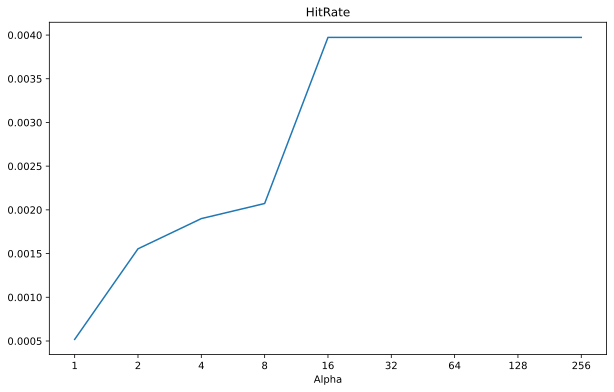

In [15]:
plt.plot(popular_results["alpha"], popular_results["metric"])
plt.xscale("log")
plt.xticks(popular_results["alpha"], popular_results["alpha"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Alpha")

plt.show()

In [16]:
popular_results = popular_results.sort_values("metric", ascending=False)

popular_results.head()

,alpha,metric
4,16,0.003973
5,32,0.003973
6,64,0.003973
7,128,0.003973
8,256,0.003973


## Pure SVD

In [18]:
ranks = [b * 2 ** p for p in range(0, 9) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768]

In [19]:
%%time
svd_results = svd_gridsearch(ranks, trainval, testval, holdoutval, data_description, topn=20)

Interaction matrix shape: (32287, 25495)
Matrix density: 0.00017608790128041966
CPU times: total: 21min 55s
Wall time: 3min 38s


In [20]:
svd_results = pd.DataFrame(svd_results)

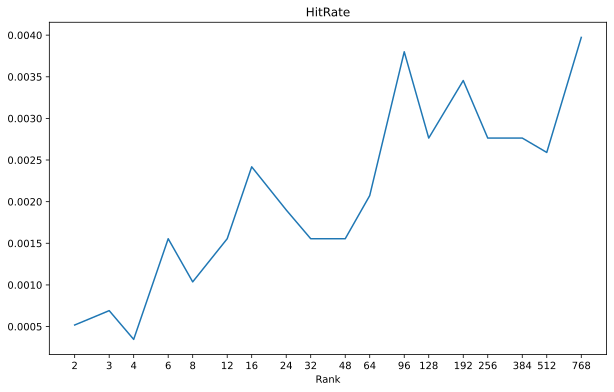

In [21]:
plt.plot(svd_results["rank"], svd_results["metric"])
plt.xscale("log")
plt.xticks(svd_results["rank"], svd_results["rank"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()

In [22]:
svd_results = svd_results.sort_values("metric", ascending=False)

svd_results.head()

,rank,metric
17,768,0.003973
11,96,0.003800
13,192,0.003455
15,384,0.002764
14,256,0.002764


## Scaled SVD

In [23]:
from scaled_svd import build_scaled_svd_model, scaled_svd_gridsearch

In [24]:
ranks = [b * 2 ** p for p in range(0, 8) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384]

In [25]:
scalings = np.arange(1, 10, 2) / 10
scalings

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [26]:
%%time
scaled_svd_results = scaled_svd_gridsearch(ranks, scalings, trainval, testval, holdoutval, data_description, topn)

Scaling 0.1


KeyboardInterrupt: 

In [29]:
results = pd.DataFrame(scaled_svd_results)

results = results.sort_values("metric", ascending=False)

results.head()

,rank,scaling,metric
75,96,0.9,0.003800
78,256,0.9,0.003109
30,256,0.3,0.002937
68,8,0.9,0.002937
77,192,0.9,0.002764


# UserKNN

In [13]:
k_vals = [10, 25, 50, 100, 200, 250, 500, 1000]
a_vals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

config = {
    'weights': False
}

In [14]:
%%time
results = uknn_gridsearch(k_vals, a_vals, config, trainval, testval, holdoutval, data_description, topn=20)

CPU times: total: 2min 26s
Wall time: 2min 28s


In [16]:
knn_results = pd.DataFrame(results)

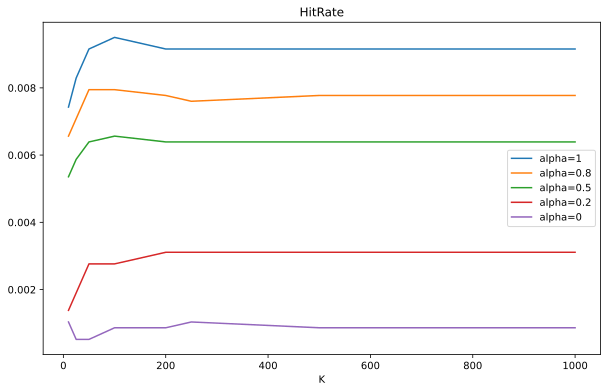

In [24]:
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==1]["metric"], label='alpha=1')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.8]["metric"], label='alpha=0.8')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.5]["metric"], label='alpha=0.5')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.2]["metric"], label='alpha=0.2')
plt.plot(k_vals, knn_results[lambda x: x["alpha"]==0.0]["metric"], label='alpha=0')
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")
plt.legend()

plt.show()

In [30]:
config = {
    'weights': True
}

In [31]:
%%time
results = uknn_gridsearch(k_vals, a_vals, config, trainval, testval, holdoutval, data_description, topn=20)

CPU times: total: 2min 31s
Wall time: 2min 33s


In [32]:
knn_results_w = pd.DataFrame(results)

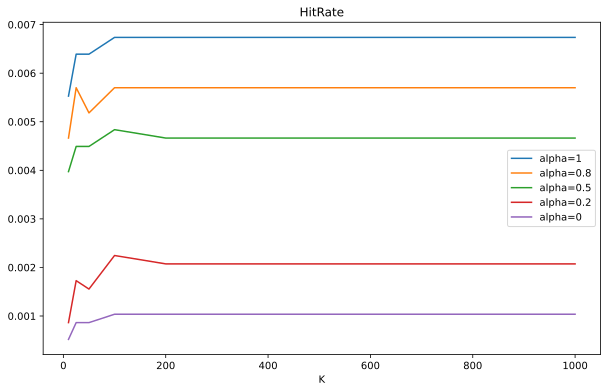

In [35]:
plt.plot(k_vals, knn_results_w[lambda x: x["alpha"]==1]["metric"], label='alpha=1')
plt.plot(k_vals, knn_results_w[lambda x: x["alpha"]==0.8]["metric"], label='alpha=0.8')
plt.plot(k_vals, knn_results_w[lambda x: x["alpha"]==0.5]["metric"], label='alpha=0.5')
plt.plot(k_vals, knn_results_w[lambda x: x["alpha"]==0.2]["metric"], label='alpha=0.2')
plt.plot(k_vals, knn_results_w[lambda x: x["alpha"]==0.0]["metric"], label='alpha=0')
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")
plt.legend()

plt.show()